
# ECG Time Series Classification

This notebook addresses the classification of ECG data into normal and Myocardial Infarction classes. Various machine learning models are explored and evaluated to determine the best performing model for this task.



# Data Preprocessing

The data preprocessing step involves loading the dataset, normalizing the features, and splitting the data into training and testing sets. Proper preprocessing is crucial for the performance of machine learning models.



# Model Building and Training

We implement and train multiple classification models including RandomForest, KNN, Logistic Regression, SVM, and an LSTM-based RNN model. The training phase includes fitting the models to the training data and tuning hyperparameters to optimize performance.



# Model Evaluation

The evaluation step involves assessing the performance of the trained models on the test set using various metrics such as accuracy, precision, recall, F1-score, and AUC. Confusion matrices and ROC curves are plotted for a comprehensive understanding of model performance.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

from keras import Sequential
# import Dense 
from keras.layers import Dense, Dropout

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from tensorflow.keras.layers import  LSTM



In [ ]:

def lstm_model(X_train, y_train):
    # Reshape the data for RNN
    X_train_rnn = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test_rnn = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # Convert class labels to integers
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    # Define the RNN model with LSTM layers
    model_rnn = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
        Dropout(0.2),
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1, activation='sigmoid')
    ])

    # Compile the model
    model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model_rnn.fit(X_train_rnn, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2)

    # Evaluate the model
    loss, accuracy = model_rnn.evaluate(X_test_rnn, y_test_encoded)
    print(f"LSTM Model Test Loss: {loss:.4f}")
    print(f"LSTM Model Test Accuracy: {accuracy:.4f}")



    # Predict probabilities
    y_prob_rnn = model_rnn.predict(X_test_rnn)
    # Threshold probabilities to get classes
    y_pred_rnn = np.where(y_prob_rnn > 0.5, 1, 0)

    # Print classification report
    print("Classification Report for LSTM Model:")
    print(classification_report(y_test_encoded, y_pred_rnn))



    # Calculate precision, recall, and F1-score
    precision_rnn = precision_score(y_test_encoded, y_pred_rnn)
    recall_rnn = recall_score(y_test_encoded, y_pred_rnn)
    f1_rnn = f1_score(y_test_encoded, y_pred_rnn)


    # Calculate AUC for LSTM model
    auc_rnn = roc_auc_score(y_test_encoded, y_prob_rnn)



    # Print precision, recall, and F1-score for LSTM model
    print("Precision for LSTM Model:", precision_rnn)
    print("Recall for LSTM Model:", recall_rnn)
    print("F1-score for LSTM Model:", f1_rnn)

    # Print AUC for LSTM model
    print("AUC for LSTM Model:", auc_rnn)


    return accuracy, precision_rnn, recall_rnn, f1_rnn, auc_rnn


In [ ]:
def  simple_neural_network(X_train, y_train):
    # Convert class labels to integers
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    # Define the neural network model without LSTM
    model_nn = Sequential([
        Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(units=32, activation='relu'),
        Dropout(0.2),
        Dense(units=1, activation='sigmoid')
    ])

    # Compile the model
    model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model_nn.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2)

    # Evaluate the model
    loss, accuracy = model_nn.evaluate(X_test, y_test_encoded)
    print(f"NN Model Test Loss: {loss:.4f}")
    print(f"NN Model Test Accuracy: {accuracy:.4f}")


    # Predict probabilities
    y_prob_nn = model_nn.predict(X_test)
    # Threshold probabilities to get classes
    y_pred_nn = np.where(y_prob_nn > 0.5, 1, 0)

    # Print classification report
    print("Classification Report for NN Model:")
    print(classification_report(y_test_encoded, y_pred_nn))



    # Calculate precision, recall, and F1-score
    precision_nn = precision_score(y_test_encoded, y_pred_nn)
    recall_nn = recall_score(y_test_encoded, y_pred_nn)
    f1_nn = f1_score(y_test_encoded, y_pred_nn)


    # Calculate AUC for simple neural network model
    auc_nn = roc_auc_score(y_test_encoded, y_prob_nn)


    # Print precision, recall, and F1-score for simple neural network model
    print("Precision for NN Model:", precision_nn)
    print("Recall for NN Model:", recall_nn)
    print("F1-score for NN Model:", f1_nn)


    # Print AUC for simple neural network model
    print("AUC for NN Model:", auc_nn)

    return accuracy, precision_nn, recall_nn, f1_nn, auc_nn




In [ ]:
def plot_roc_curve(fpr, tpr, roc_auc):
    # Plot ROC curve
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


def plot_confusion_matrix(confusion_matrix):
    # Visualize confusion matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def performance_metrics(precision_scores, recall_scores, f1_scores, auc_scores):
    # Plot the evaluation metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Performance Metrics of Different Models', fontsize=16)

    # Precision
    axes[0, 0].bar(precision_scores.keys(), precision_scores.values(), color='skyblue')
    axes[0, 0].set_title('Precision')
    axes[0, 0].set_ylabel('Precision')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Recall
    axes[0, 1].bar(recall_scores.keys(), recall_scores.values(), color='lightgreen')
    axes[0, 1].set_title('Recall')
    axes[0, 1].set_ylabel('Recall')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # F1-score
    axes[1, 0].bar(f1_scores.keys(), f1_scores.values(), color='salmon')
    axes[1, 0].set_title('F1-score')
    axes[1, 0].set_ylabel('F1-score')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # AUC
    axes[1, 1].bar(auc_scores.keys(), auc_scores.values(), color='lightcoral')
    axes[1, 1].set_title('AUC')
    axes[1, 1].set_ylabel('AUC')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


<h2>Importing the data and transform it into DataFrame</h2>

In [ ]:
columns = ['Class'] + [f'Time_{i}' for i in range(1, 97)]

df = pd.read_csv('ECG200_TRAIN.txt', delimiter='\s+', header=None, names=columns)

df


,Class,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9,...,Time_87,Time_88,Time_89,Time_90,Time_91,Time_92,Time_93,Time_94,Time_95,Time_96
0,-1.0,0.502055,0.542163,0.722383,1.428885,2.136516,2.281149,1.936274,1.468890,1.008845,...,0.931043,0.610298,0.638894,0.684679,0.583238,0.640522,0.708585,0.705011,0.713815,0.433765
1,1.0,0.147647,0.804668,0.367771,0.243894,0.026614,-0.274402,0.096731,-0.747731,-1.609777,...,-0.533503,-0.400228,0.176084,1.111768,2.438428,2.734889,1.736054,0.036857,-1.265074,-0.208024
2,-1.0,0.316646,0.243199,0.370471,1.063738,1.678187,1.759558,1.697717,1.612159,1.168188,...,0.764229,0.610621,0.552900,0.566786,0.604002,0.777068,0.812345,0.748848,0.818042,0.539347
3,-1.0,1.168874,2.075901,1.760141,1.606446,1.949046,1.302842,0.459332,0.516412,0.852180,...,0.419006,0.723888,1.323947,2.136488,1.746597,1.470220,1.893512,1.256949,0.800407,0.731540
4,1.0,0.648658,0.752026,2.636231,3.455716,2.118157,0.520620,-0.188627,0.780818,0.933775,...,-0.097869,-0.136787,-0.340237,-0.089441,-0.080297,-0.192584,-0.304704,-0.454556,0.314590,0.582190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,0.581277,0.876188,1.042767,1.796120,2.541399,2.246653,1.500387,1.031521,0.382672,...,1.002770,0.907869,0.916457,0.923975,0.767357,0.656223,0.762357,0.501373,-0.333336,-0.524546
96,-1.0,2.689017,2.708703,2.008381,2.235800,1.516982,0.029916,-0.561346,-0.793702,-0.979371,...,-0.136610,-0.072176,-0.082738,-0.138468,-0.120396,-0.089411,-0.243141,-0.119710,0.124042,0.273463
97,-1.0,0.197677,0.455417,0.973110,1.935956,2.259463,1.741341,1.158296,0.418241,-0.071605,...,0.482452,0.325569,0.247991,0.184127,0.050358,0.241988,0.331451,-0.120006,0.042423,0.343293
98,1.0,0.179500,1.038409,1.946421,2.705141,1.670706,-0.101167,-1.578876,-0.750906,0.175310,...,0.324323,0.330489,0.111953,0.448948,0.567132,0.136757,0.444768,0.151050,0.193378,0.451709


<h2>Class distribution</h2>

In [ ]:
class_distribution = df['Class'].value_counts()
print(class_distribution)

Class
 1.0    69
-1.0    31
Name: count, dtype: int64


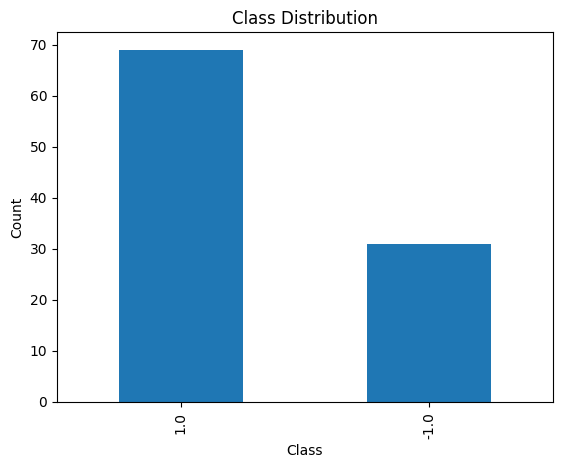

In [ ]:
# Plot the class distribution
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

<h5>This distribution indicates that the dataset is imbalanced, with more instances of normal heartbeats (class 1.0) compared to myocardial infarctions (class -1.0). An imbalanced dataset can affect the performance of machine learning models, often leading to a model that is biased towards the majority class.</h5>

<h2>Handling missing values</h2>

In [ ]:
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 Class      0
Time_1     0
Time_2     0
Time_3     0
Time_4     0
          ..
Time_92    0
Time_93    0
Time_94    0
Time_95    0
Time_96    0
Length: 97, dtype: int64


In [ ]:
df.fillna(df.mean(), inplace=True)


<h2>Verifying the features of the data</h2>

In [ ]:
df.describe()

,Class,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9,...,Time_87,Time_88,Time_89,Time_90,Time_91,Time_92,Time_93,Time_94,Time_95,Time_96
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.380000,0.708438,1.422151,2.039149,2.126455,1.551616,0.762251,0.282647,0.333630,0.372973,...,0.190412,0.174286,0.205107,0.286484,0.412464,0.459377,0.389852,0.282864,0.182829,0.174863
std,0.929646,0.593513,0.927972,1.046880,1.098754,0.954734,0.963111,1.096712,0.877640,0.761753,...,0.403825,0.434002,0.454395,0.589879,0.772104,0.871045,0.832312,0.665548,0.619799,0.413644
min,-1.000000,-0.706305,-1.100715,-1.321589,-1.076313,-1.247922,-1.482391,-1.598712,-1.508060,-1.609777,...,-0.533503,-0.691436,-0.516631,-0.574304,-0.559178,-0.530917,-0.738019,-0.970796,-1.862314,-1.238622
25%,-1.000000,0.318643,0.779810,1.525548,1.511639,0.966292,0.022470,-0.603378,-0.464767,-0.075355,...,-0.131730,-0.140244,-0.121657,-0.144015,-0.070247,-0.098634,-0.107719,-0.119784,-0.124178,-0.043105
50%,1.000000,0.581008,1.232191,2.152552,2.234408,1.746861,0.574297,0.120230,0.366122,0.457255,...,0.086719,0.089474,0.107957,0.129133,0.170798,0.205220,0.101618,0.136106,0.124148,0.152284
75%,1.000000,0.994760,2.093703,2.707411,2.865394,2.163355,1.502335,1.226563,1.008876,0.990675,...,0.439861,0.468588,0.480635,0.613990,0.588429,0.630966,0.560136,0.594807,0.541680,0.429055
max,1.000000,2.689017,3.535038,3.850263,4.199145,3.720899,3.026452,2.454195,2.220327,2.122435,...,1.376751,1.497244,1.436900,2.190151,3.047309,3.269882,3.332053,2.653741,1.930880,1.372607


<h2>Spltting the df</h2>

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']

<h2>Normalizing the data</h2>

In [ ]:
global_max = X.values.max()
global_min = X.values.min()

X_normalized = (X - global_min) / (global_max - global_min)

In [ ]:
df[X.columns] = X_normalized

In [ ]:
df.describe()

,Class,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9,...,Time_87,Time_88,Time_89,Time_90,Time_91,Time_92,Time_93,Time_94,Time_95,Time_96
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.380000,0.487890,0.592596,0.683114,0.695922,0.611590,0.495784,0.425423,0.432903,0.438675,...,0.411892,0.409526,0.414048,0.425986,0.444468,0.451351,0.441151,0.425455,0.410779,0.409611
std,0.929646,0.087072,0.136140,0.153584,0.161195,0.140066,0.141295,0.160895,0.128756,0.111754,...,0.059244,0.063671,0.066663,0.086539,0.113273,0.127788,0.122106,0.097640,0.090929,0.060684
min,-1.000000,0.280338,0.222475,0.190071,0.226055,0.200879,0.166480,0.149415,0.162715,0.147792,...,0.305689,0.282519,0.308164,0.299703,0.301922,0.306068,0.275685,0.241535,0.110743,0.202243
25%,-1.000000,0.430704,0.498361,0.607765,0.605725,0.525719,0.387254,0.295438,0.315773,0.372902,...,0.364631,0.363382,0.366109,0.362829,0.373651,0.369487,0.368154,0.366384,0.365739,0.377633
50%,1.000000,0.469195,0.564728,0.699751,0.711760,0.640233,0.468210,0.401596,0.437670,0.451040,...,0.396679,0.397084,0.399795,0.402902,0.409014,0.414064,0.398865,0.403925,0.402170,0.406298
75%,1.000000,0.529895,0.691118,0.781153,0.804330,0.701336,0.604360,0.563902,0.531966,0.529296,...,0.448488,0.452702,0.454470,0.474034,0.470284,0.476524,0.466133,0.471219,0.463425,0.446902
max,1.000000,0.778454,0.902571,0.948817,1.000000,0.929838,0.827958,0.744004,0.709694,0.695333,...,0.585936,0.603613,0.594760,0.705267,0.831018,0.863671,0.872792,0.773279,0.667230,0.585328


In [ ]:
X = df.drop('Class', axis=1)


<h2>Plotting some samples</h2>

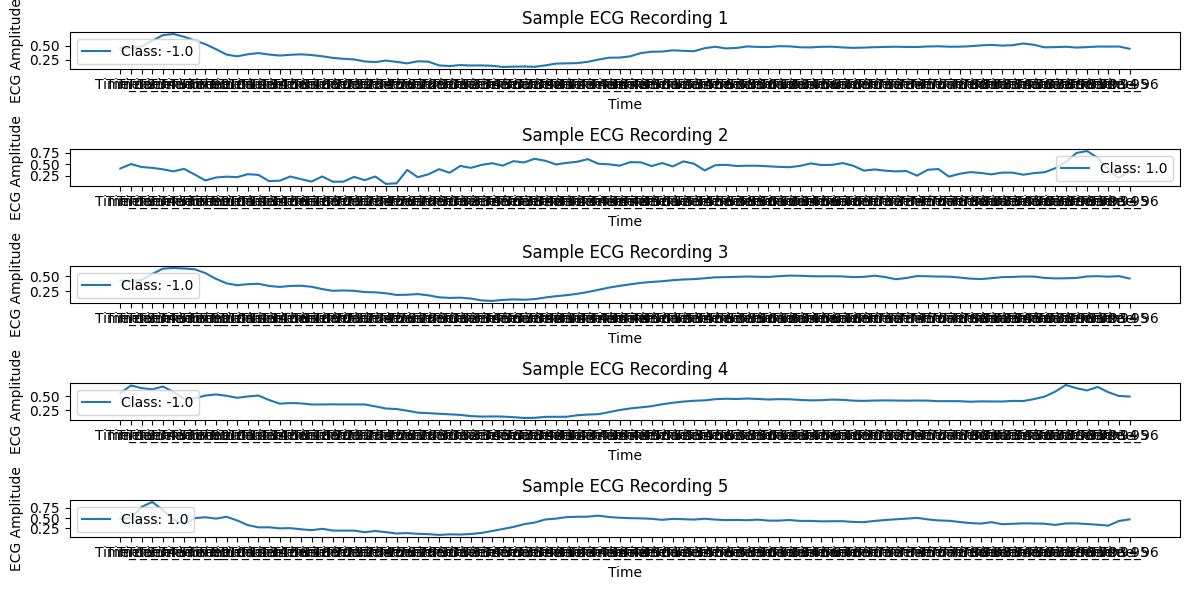

In [ ]:

num_samples_to_plot = 5

plt.figure(figsize=(12, 6))

for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    plt.plot(X.iloc[i], label=f"Class: {y.iloc[i]}")
    plt.xlabel('Time')
    plt.ylabel('ECG Amplitude')
    plt.title(f'Sample ECG Recording {i+1}')
    plt.legend()

plt.tight_layout()
plt.show()


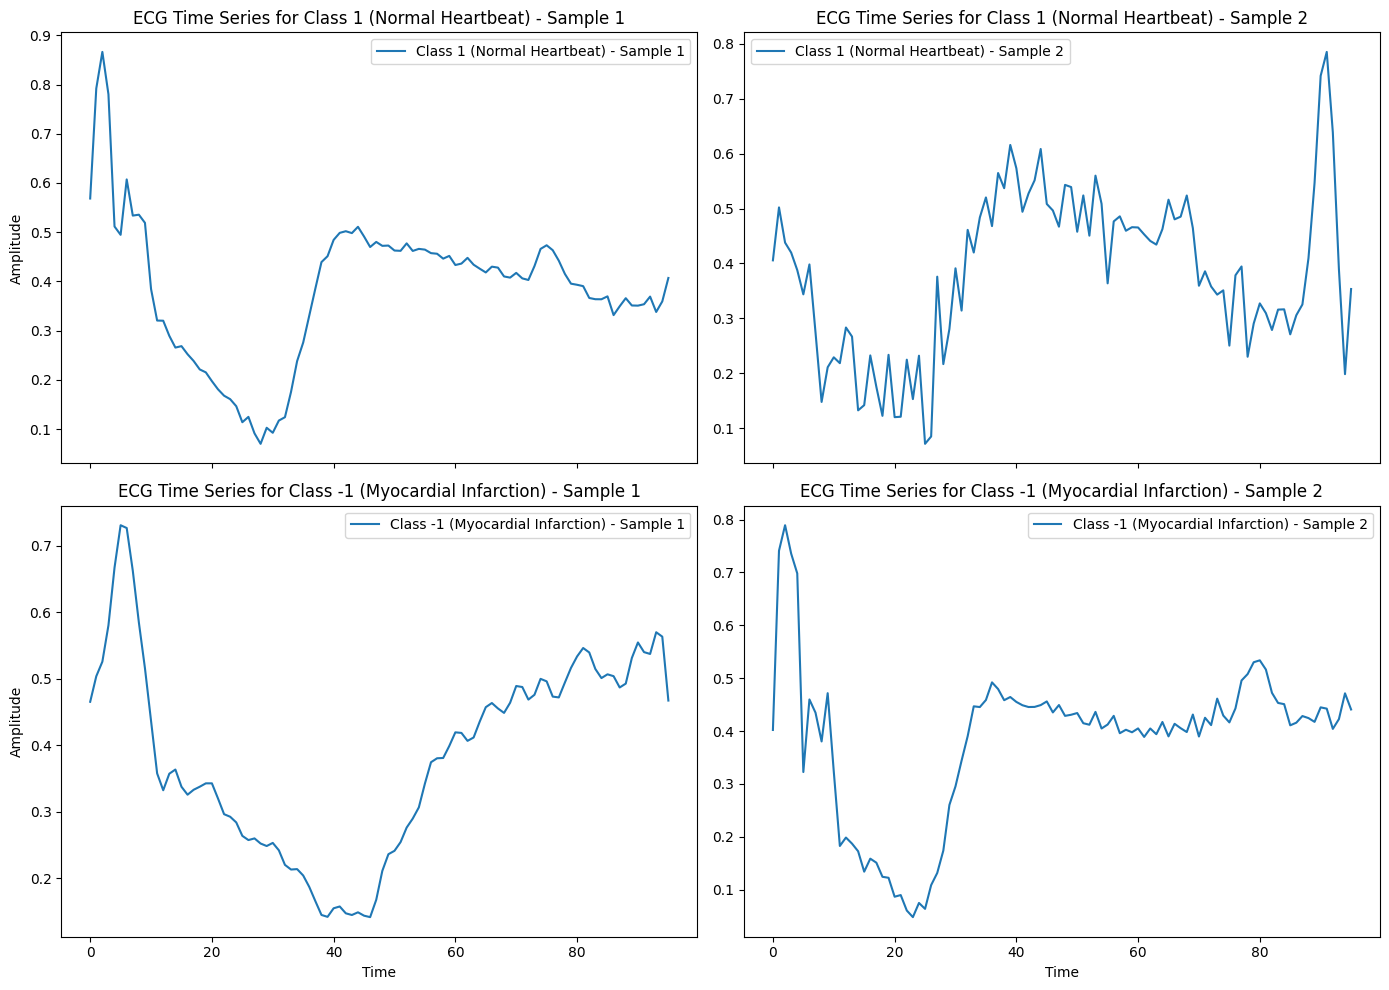

In [ ]:
# Separate data by class
df_class_1 = df[df['Class'] == 1]
df_class_minus_1 = df[df['Class'] == -1]

# Randomly select two samples from each class
samples_class_1 = df_class_1.sample(n=2, random_state=42).values
samples_class_minus_1 = df_class_minus_1.sample(n=2, random_state=42).values

# Extract the time series data (excluding the class label)
time_series_class_1_sample1 = samples_class_1[0, 1:]
time_series_class_1_sample2 = samples_class_1[1, 1:]
time_series_class_minus_1_sample1 = samples_class_minus_1[0, 1:]
time_series_class_minus_1_sample2 = samples_class_minus_1[1, 1:]

# Plot the time series data for each sample
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# Plot for Class 1
axs[0, 0].plot(time_series_class_1_sample1, label='Class 1 (Normal Heartbeat) - Sample 1')
axs[0, 0].set_title('ECG Time Series for Class 1 (Normal Heartbeat) - Sample 1')
axs[0, 0].set_ylabel('Amplitude')
axs[0, 0].legend()

axs[0, 1].plot(time_series_class_1_sample2, label='Class 1 (Normal Heartbeat) - Sample 2')
axs[0, 1].set_title('ECG Time Series for Class 1 (Normal Heartbeat) - Sample 2')
axs[0, 1].legend()

# Plot for Class -1
axs[1, 0].plot(time_series_class_minus_1_sample1, label='Class -1 (Myocardial Infarction) - Sample 1')
axs[1, 0].set_title('ECG Time Series for Class -1 (Myocardial Infarction) - Sample 1')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Amplitude')
axs[1, 0].legend()

axs[1, 1].plot(time_series_class_minus_1_sample2, label='Class -1 (Myocardial Infarction) - Sample 2')
axs[1, 1].set_title('ECG Time Series for Class -1 (Myocardial Infarction) - Sample 2')
axs[1, 1].set_xlabel('Time')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

<h2>Splitting the data</h2>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<h2>Class distribution in training set</h2>

In [ ]:
class_distribution_train = pd.Series(y_train).value_counts()
print("Class distribution in the training set: ")
print(class_distribution_train)

Class distribution in the training set: 
Class
 1.0    55
-1.0    25
Name: count, dtype: int64


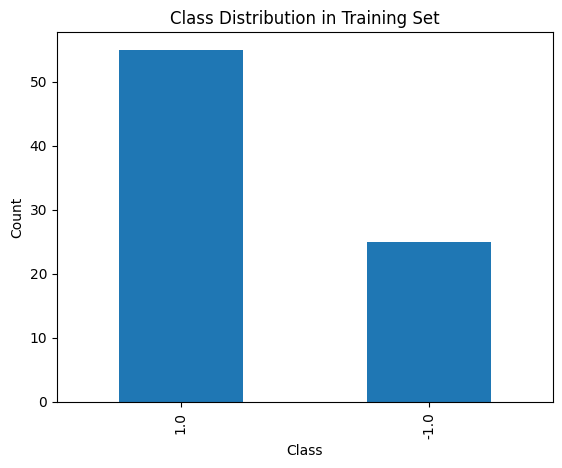

In [ ]:
class_distribution_train.plot(kind="bar")
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Training Set')
plt.show()

<h5> this class distribution indicates an imbalance in the training set. There are significantly more instances of normal heartbeats (Class 1.0) than instances of myocardial infarctions (Class -1.0).</h5>

<h1> MODELS </h1>

<h1>Random Forest</h1>

Classification Report:
               precision    recall  f1-score   support

        -1.0       0.67      0.67      0.67         6
         1.0       0.86      0.86      0.86        14

    accuracy                           0.80        20
   macro avg       0.76      0.76      0.76        20
weighted avg       0.80      0.80      0.80        20



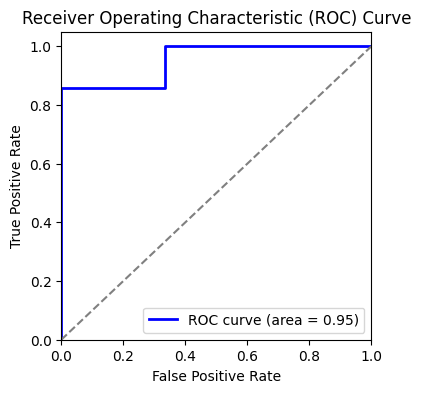

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, rf_y_pred))

rf_y_pred_proba = rf.predict_proba(X_test)[:, 1]

rf_fpr, rf_tpr, thresholds = roc_curve(y_test, rf_y_pred_proba)
rf_roc_auc = auc(rf_fpr, rf_tpr)

plot_roc_curve(rf_fpr, rf_tpr, rf_roc_auc)


<H1>KNN</H1>

KNN Classification Report:
               precision    recall  f1-score   support

        -1.0       0.86      1.00      0.92         6
         1.0       1.00      0.93      0.96        14

    accuracy                           0.95        20
   macro avg       0.93      0.96      0.94        20
weighted avg       0.96      0.95      0.95        20



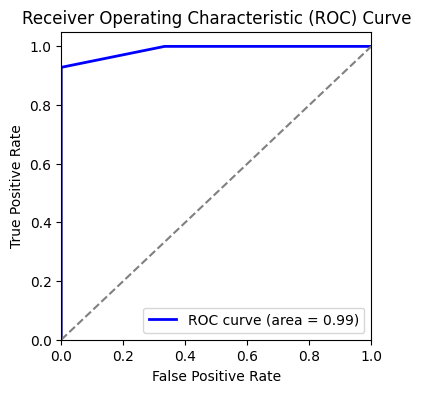

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train, y_train)
knn_y_pred = knn_model.predict(X_test)
print("KNN Classification Report:\n", classification_report(y_test, knn_y_pred))

knn_y_pred_proba = knn_model.predict_proba(X_test)[:, 1]

knn_fpr, knn_tpr, thresholds = roc_curve(y_test, knn_y_pred_proba)
knn_roc_auc = auc(knn_fpr, knn_tpr)

plot_roc_curve(knn_fpr, knn_tpr, knn_roc_auc)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Initialize variables to accumulate scores
acc_scores = []
auc_scores = []

# Setup Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop over each fold
for train_index, test_index in skf.split(X, y):
    
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]    
    
    # Initialize and train the KNN model
    knn_model = KNeighborsClassifier(n_neighbors=2)
    knn_model.fit(X_train_fold, y_train_fold)
    
    # Predictions
    y_pred_fold = knn_model.predict(X_test_fold)
    y_pred_proba_fold = knn_model.predict_proba(X_test_fold)[:, 1]
    
    # Calculate scores
    acc_score = knn_model.score(X_test_fold, y_test_fold)
    auc_score = roc_auc_score(y_test_fold, y_pred_proba_fold)
    
    # Append scores
    acc_scores.append(acc_score)
    auc_scores.append(auc_score)

# Calculate average scores
avg_acc_score = np.mean(acc_scores)
avg_auc_score = np.mean(auc_scores)

print(f"Average Accuracy: {avg_acc_score:.4f}")
print(f"Average AUC: {avg_auc_score:.4f}")

Average Accuracy: 0.8600
Average AUC: 0.8884


In [ ]:
from sklearn.metrics import recall_score

# Initialize a list to accumulate recall scores for class -1.0
recall_scores = []

# Loop over each fold
for train_index, test_index in skf.split(X, y):
    
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]    
    # Initialize and train the KNN model
    knn_model = KNeighborsClassifier(n_neighbors=2)
    knn_model.fit(X_train_fold, y_train_fold)
    
    # Predictions
    y_pred_fold = knn_model.predict(X_test_fold)
    
    # Calculate recall for class -1.0
    recall = recall_score(y_test_fold, y_pred_fold, pos_label=-1.0)
    
    # Append recall score
    recall_scores.append(recall)

# Calculate average recall for class -1.0
avg_recall_score = np.mean(recall_scores)

print(f"Average Recall for class -1.0: {avg_recall_score:.4f}")

Average Recall for class -1.0: 0.8333


<h1>Logistic Regression</h1>

Logistic Regression Classification Report:
               precision    recall  f1-score   support

        -1.0       0.67      0.33      0.44         6
         1.0       0.76      0.93      0.84        14

    accuracy                           0.75        20
   macro avg       0.72      0.63      0.64        20
weighted avg       0.74      0.75      0.72        20



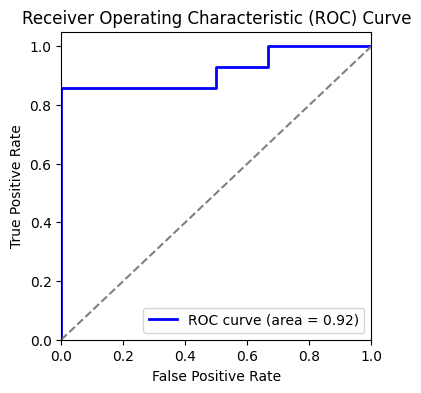

In [ ]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
logistic_y_pred = logistic_model.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, logistic_y_pred))


lr_y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

lr_fpr, lr_tpr, thresholds = roc_curve(y_test, lr_y_pred_proba)
lr_roc_auc = auc(lr_fpr, lr_tpr)

plot_roc_curve(lr_fpr, lr_tpr, lr_roc_auc)


<h1>SVM</h1>

SVM Classification Report:
               precision    recall  f1-score   support

        -1.0       0.75      0.50      0.60         6
         1.0       0.81      0.93      0.87        14

    accuracy                           0.80        20
   macro avg       0.78      0.71      0.73        20
weighted avg       0.79      0.80      0.79        20



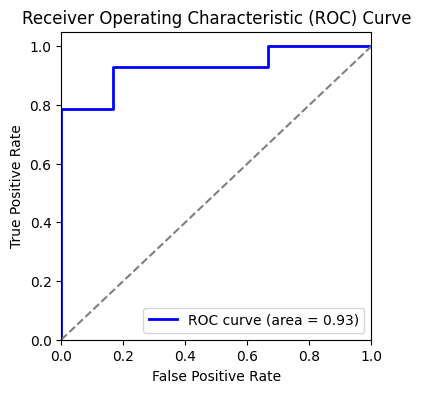

In [ ]:
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
svm_y_pred = svm_model.predict(X_test)
print("SVM Classification Report:\n", classification_report(y_test, svm_y_pred))


svm_y_pred_proba = svm_model.predict_proba(X_test)[:, 1]

svm_fpr, svm_tpr, thresholds = roc_curve(y_test, svm_y_pred_proba)
svm_roc_auc = auc(svm_fpr, svm_tpr)

plot_roc_curve(svm_fpr, svm_tpr, svm_roc_auc)

<h1>AdaBoost</h1>

/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classification Report:
               precision    recall  f1-score   support

        -1.0       0.71      0.83      0.77         6
         1.0       0.92      0.86      0.89        14

    accuracy                           0.85        20
   macro avg       0.82      0.85      0.83        20
weighted avg       0.86      0.85      0.85        20



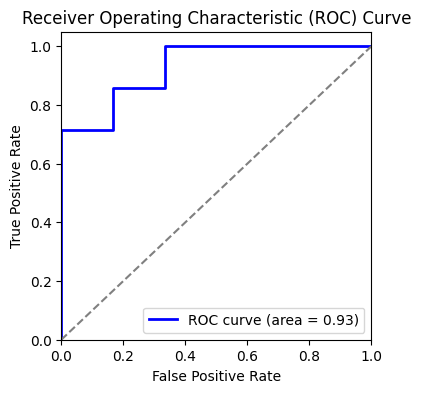

In [ ]:
ada_boost_model = AdaBoostClassifier()
ada_boost_model.fit(X_train, y_train)
ada_boost_y_pred = ada_boost_model.predict(X_test)
print("AdaBoost Classification Report:\n", classification_report(y_test, ada_boost_y_pred))


adb_y_pred_proba = ada_boost_model.predict_proba(X_test)[:, 1]

adb_fpr, adb_tpr, thresholds = roc_curve(y_test, adb_y_pred_proba)
adb_roc_auc = auc(adb_fpr, adb_tpr)

plot_roc_curve(adb_fpr, adb_tpr, adb_roc_auc)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, auc, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to accumulate scores
acc_scores = []
auc_scores = []

# Setup Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop over each fold
for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and train the AdaBoost model
    ada_boost_model = AdaBoostClassifier()
    ada_boost_model.fit(X_train_fold, y_train_fold)
    
    # Predictions
    y_pred_fold = ada_boost_model.predict(X_test_fold)
    y_pred_proba_fold = ada_boost_model.predict_proba(X_test_fold)[:, 1]
    
    # Calculate scores
    acc_score = ada_boost_model.score(X_test_fold, y_test_fold)
    auc_score = roc_auc_score(y_test_fold, y_pred_proba_fold)
    
    # Append scores
    acc_scores.append(acc_score)
    auc_scores.append(auc_score)

# Calculate average scores
avg_acc_score = np.mean(acc_scores)
avg_auc_score = np.mean(auc_scores)

print(f"Average Accuracy: {avg_acc_score:.4f}")
print(f"Average AUC: {avg_auc_score:.4f}")

/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

Average Accuracy: 0.8200
Average AUC: 0.8962


/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


<h1>GradientBoost</h1>

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

        -1.0       0.67      0.67      0.67         6
         1.0       0.86      0.86      0.86        14

    accuracy                           0.80        20
   macro avg       0.76      0.76      0.76        20
weighted avg       0.80      0.80      0.80        20



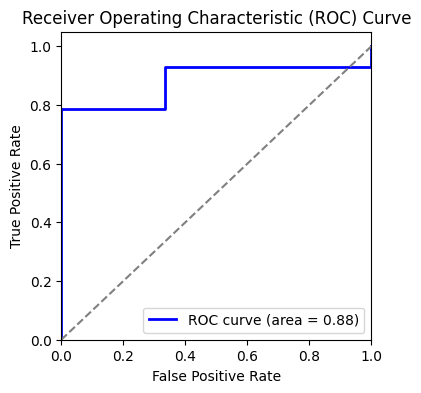

In [ ]:
gradient_boost_model = GradientBoostingClassifier()
gradient_boost_model.fit(X_train, y_train)
gradient_boost_y_pred = gradient_boost_model.predict(X_test)
print("Gradient Boosting Classification Report:\n", classification_report(y_test, gradient_boost_y_pred))


gb_y_pred_proba = gradient_boost_model.predict_proba(X_test)[:, 1]

gb_fpr, gb_tpr, thresholds = roc_curve(y_test, gb_y_pred_proba)
gb_roc_auc = auc(gb_fpr, gb_tpr)

plot_roc_curve(gb_fpr, gb_tpr, gb_roc_auc)

<h2> Handling class imbalance</h2>

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution in the resampled training set
class_distribution_resampled = pd.Series(y_train_resampled).value_counts()
print("Class distribution in the resampled training set:")
print(class_distribution_resampled)

Class distribution in the resampled training set:
Class
 1.0    55
-1.0    55
Name: count, dtype: int64


<h2> Training the models after handling class imbalance</h2>

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

resampled_precision_scores = {}
resampled_recall_scores = {}
resampled_f1_scores = {}
resampled_auc_scores = {}

models = {
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)


    resampled_precision_scores[name] = precision
    resampled_recall_scores[name] = recall
    resampled_f1_scores[name] = f1
    resampled_auc_scores[name] = auc

/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


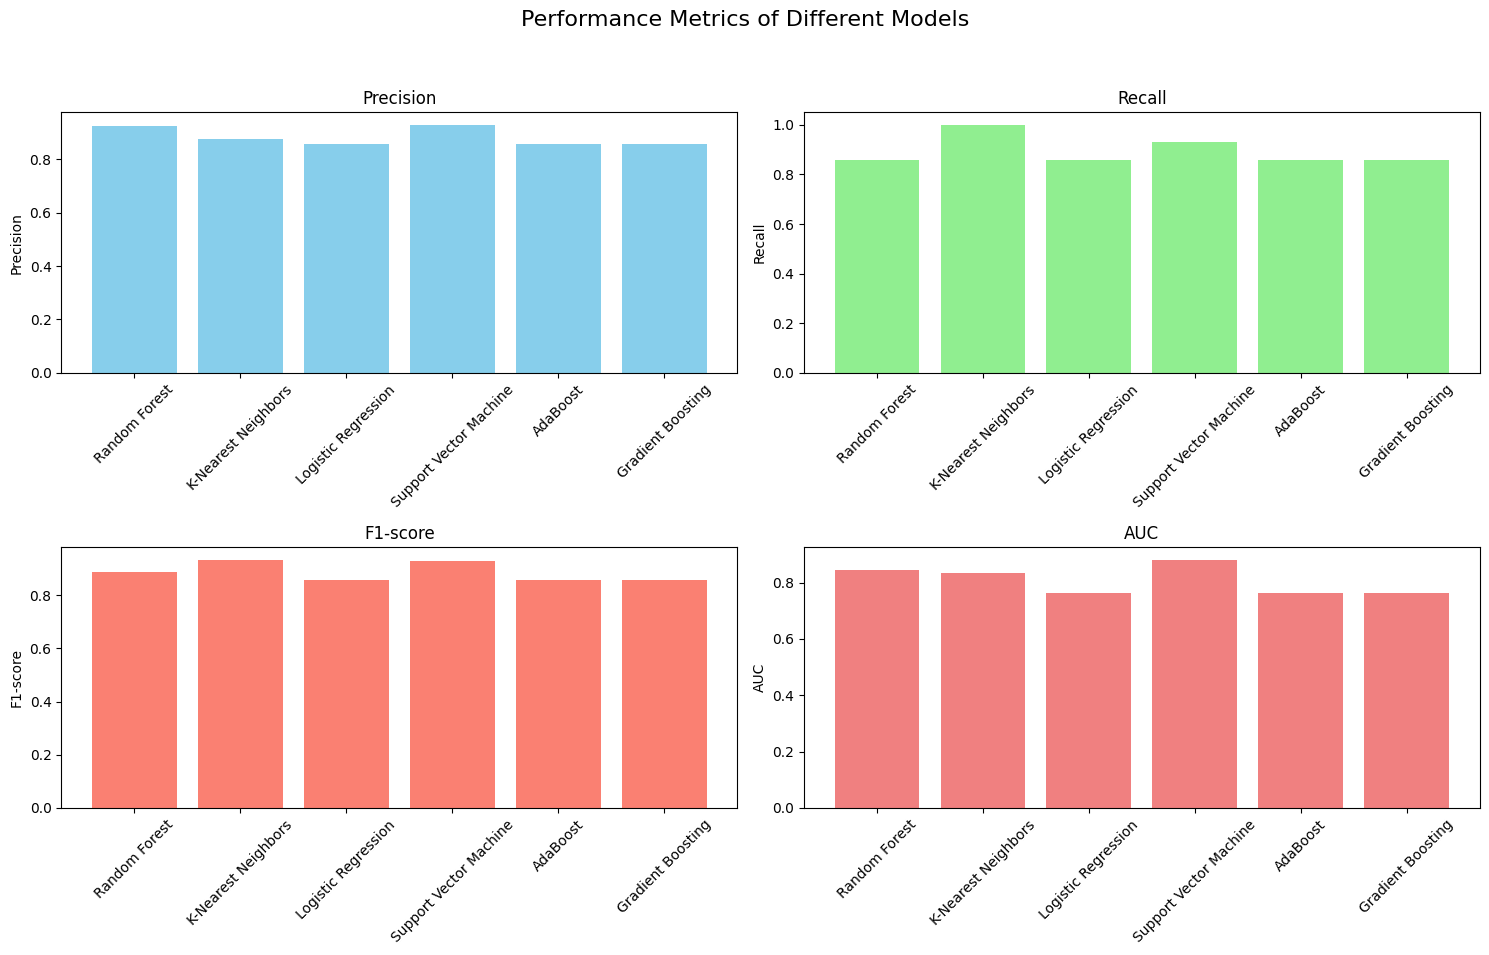

In [ ]:
performance_metrics(resampled_precision_scores, resampled_recall_scores, resampled_f1_scores, resampled_auc_scores)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

precision_scores = {}
recall_scores = {}
f1_scores = {}
auc_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision_scores[name] = precision_score(y_test, y_pred)
    recall_scores[name] = recall_score(y_test, y_pred)
    f1_scores[name] = f1_score(y_test, y_pred)
    auc_scores[name] = roc_auc_score(y_test, y_pred)

/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


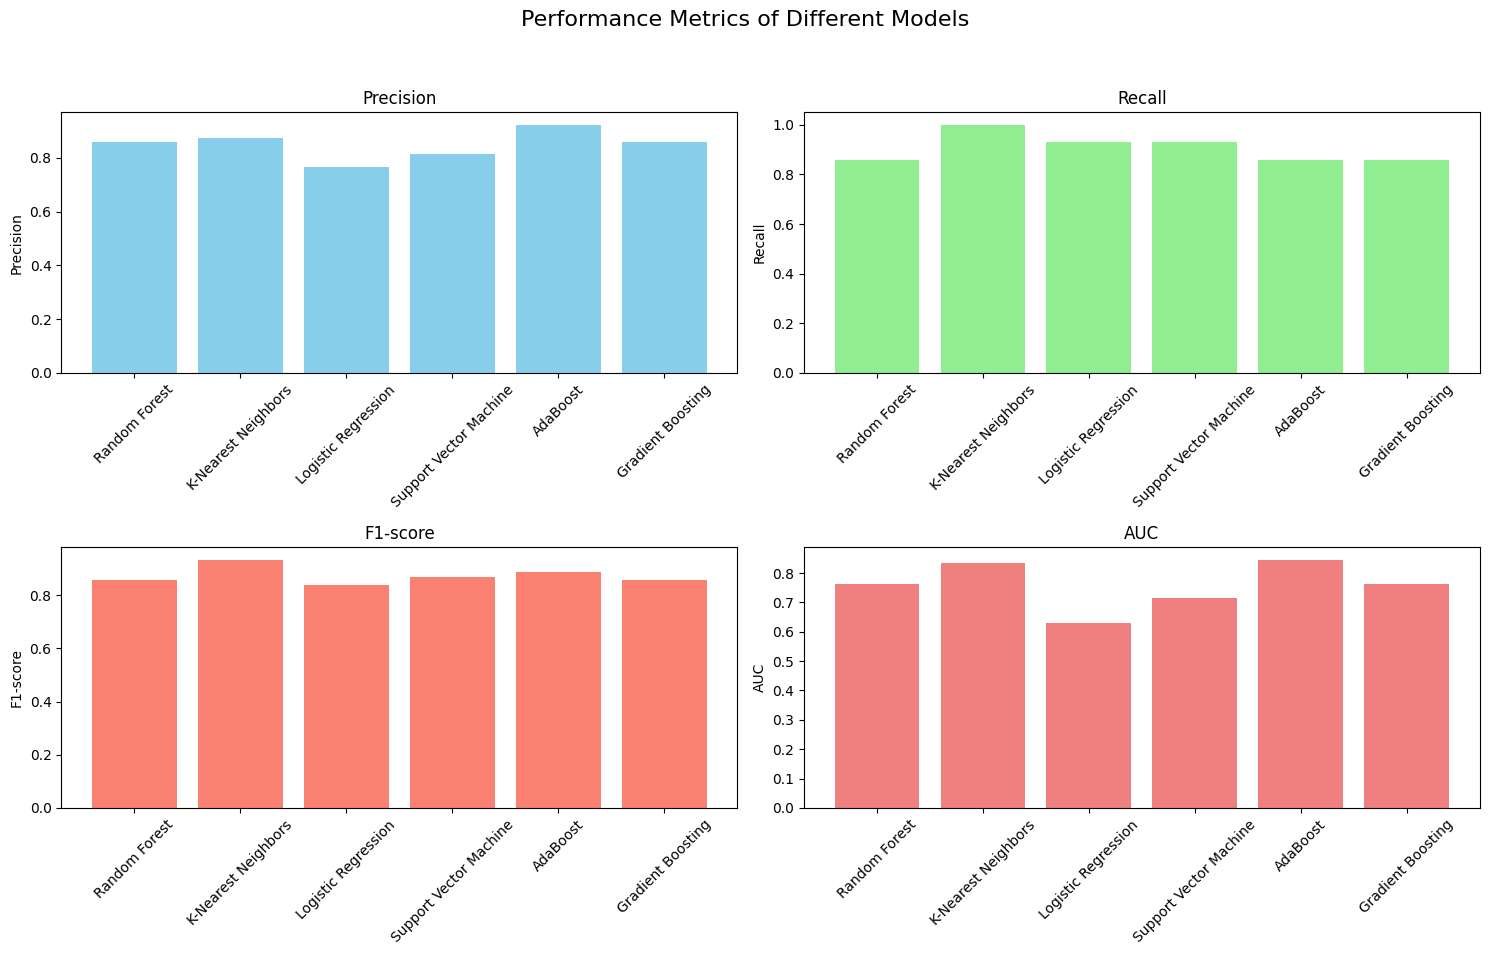

In [ ]:
performance_metrics(precision_scores, recall_scores, f1_scores, auc_scores )

<h5> - After applying resampling, we notice an improvement the performance of all the models overall, especially the Logistic Regression model where the recall for the negative class went from 0.33 to 0.67 as well as the f1_score that went from 0.44 to 0.67.
Beside the slight drop in the accuracy of  and Gradient Boosting model, its performance has improved  </h5>

<h5> - The Random Forest model performs better on the original data.</h5>

<h2> Deep Learning models</h2>

<h2> Simple Neural Network</h2>

<h3> Using original resampled data</h3>

In [ ]:
resampled_accuracy_nn, resampled_precision_nn, resampled_recall_nn, resampled_f1_score_nn, resampled_auc_nn = simple_neural_network(X_train_resampled, y_train_resampled)

Epoch 1/50


/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.5941 - loss: 0.6717 - val_accuracy: 0.0000e+00 - val_loss: 0.9012
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6541 - loss: 0.6204 - val_accuracy: 0.0000e+00 - val_loss: 1.0227
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6541 - loss: 0.6413 - val_accuracy: 0.0000e+00 - val_loss: 1.0821
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5955 - loss: 0.6702 - val_accuracy: 0.0000e+00 - val_loss: 1.0555
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6190 - loss: 0.6410 - val_accuracy: 0.0000e+00 - val_loss: 1.0118
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7156 - loss: 0.6041 - val_accuracy: 0.0000e+00 - val_loss: 0.9742
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6598 - loss: 0.6034 - val_accuracy: 0.0000e+00 - val_loss: 0.9258
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6520 - loss: 0.6218 - val_accuracy: 0.0455 - 

<h3> Using original training data</h3>

In [ ]:
accuracy, precision_nn, recall_nn, f1_score_nn, auc_nn = simple_neural_network(X_train, y_train)

Epoch 1/50


/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.4688 - loss: 0.7036 - val_accuracy: 0.8125 - val_loss: 0.6177
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6562 - loss: 0.6384 - val_accuracy: 0.7500 - val_loss: 0.5697
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7396 - loss: 0.5960 - val_accuracy: 0.7500 - val_loss: 0.5391
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.6875 - loss: 0.5800 - val_accuracy: 0.7500 - val_loss: 0.5192
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6979 - loss: 0.6090 - val_accuracy: 0.7500 - val_loss: 0.5082
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6667 - loss: 0.5935 - val_accuracy: 0.7500 - val_loss: 0.5005
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6250 - loss: 0.6196 - val_accuracy: 0.7500 - val_loss: 0.4945
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6354 - loss: 0.6163 - val_accuracy: 0.7500 - val_loss: 0.4899
Epoch 9/50

<h2> LSTM</h2>

<h3> Using resampled training data</h3>

In [ ]:
resampled_accuracy_rnn, resampled_precision_rnn, resampled_recall_rnn, resampled_f1_score_rnn, resampled_auc_rnn = lstm_model(X_train_resampled, y_train_resampled)

Epoch 1/20


/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.5382 - loss: 0.6924 - val_accuracy: 0.0000e+00 - val_loss: 0.7086
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6254 - loss: 0.6886 - val_accuracy: 0.0000e+00 - val_loss: 0.7260
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5711 - loss: 0.6858 - val_accuracy: 0.0000e+00 - val_loss: 0.7514
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5698 - loss: 0.6821 - val_accuracy: 0.0000e+00 - val_loss: 0.7948
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6065 - loss: 0.6726 - val_accuracy: 0.0000e+00 - val_loss: 0.8646
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6391 - loss: 0.6552 - val_accuracy: 0.0000e+00 - val_loss: 0.9548
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6548 - loss: 0.6365 - val_accuracy: 0.0000e+00 - val_loss: 1.0369
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6667 - loss: 0.6228 - val_accuracy: 0.0000e+00 - v

In [ ]:
accuracy_rnn, precision_rnn, recall_rnn, f1_score_rnn, auc_rnn = lstm_model(X_train, y_train)

Epoch 1/50


/home/moon/anaconda3/envs/lab1/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 711ms/step - accuracy: 0.5938 - loss: 0.6926 - val_accuracy: 0.7500 - val_loss: 0.6897
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6458 - loss: 0.6901 - val_accuracy: 0.7500 - val_loss: 0.6861
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6771 - loss: 0.6876 - val_accuracy: 0.7500 - val_loss: 0.6819
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6771 - loss: 0.6842 - val_accuracy: 0.7500 - val_loss: 0.6771
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6875 - loss: 0.6818 - val_accuracy: 0.7500 - val_loss: 0.6716
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6979 - loss: 0.6756 - val_accuracy: 0.7500 - val_loss: 0.6652
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6875 - loss: 0.6738 - val_accuracy: 0.7500 - val_loss: 0.6579
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6667 - loss: 0.6677 - val_accuracy: 0.7500 - val_loss: 0.6492
Epoch 9/50

In [ ]:
# Append precision, recall, and F1-score to the existing dictionaries
resampled_precision_scores['LSTM'] = resampled_precision_rnn
resampled_recall_scores['LSTM'] = resampled_recall_rnn
resampled_f1_scores['LSTM'] = resampled_f1_score_rnn
resampled_auc_scores['LSTM'] = resampled_auc_rnn

# Append precision, recall, and F1-score to the existing dictionaries
resampled_precision_scores['NN'] = resampled_precision_nn
resampled_recall_scores['NN'] = resampled_recall_nn
resampled_f1_scores['NN'] = resampled_f1_score_rnn
resampled_auc_scores['NN'] = resampled_auc_nn



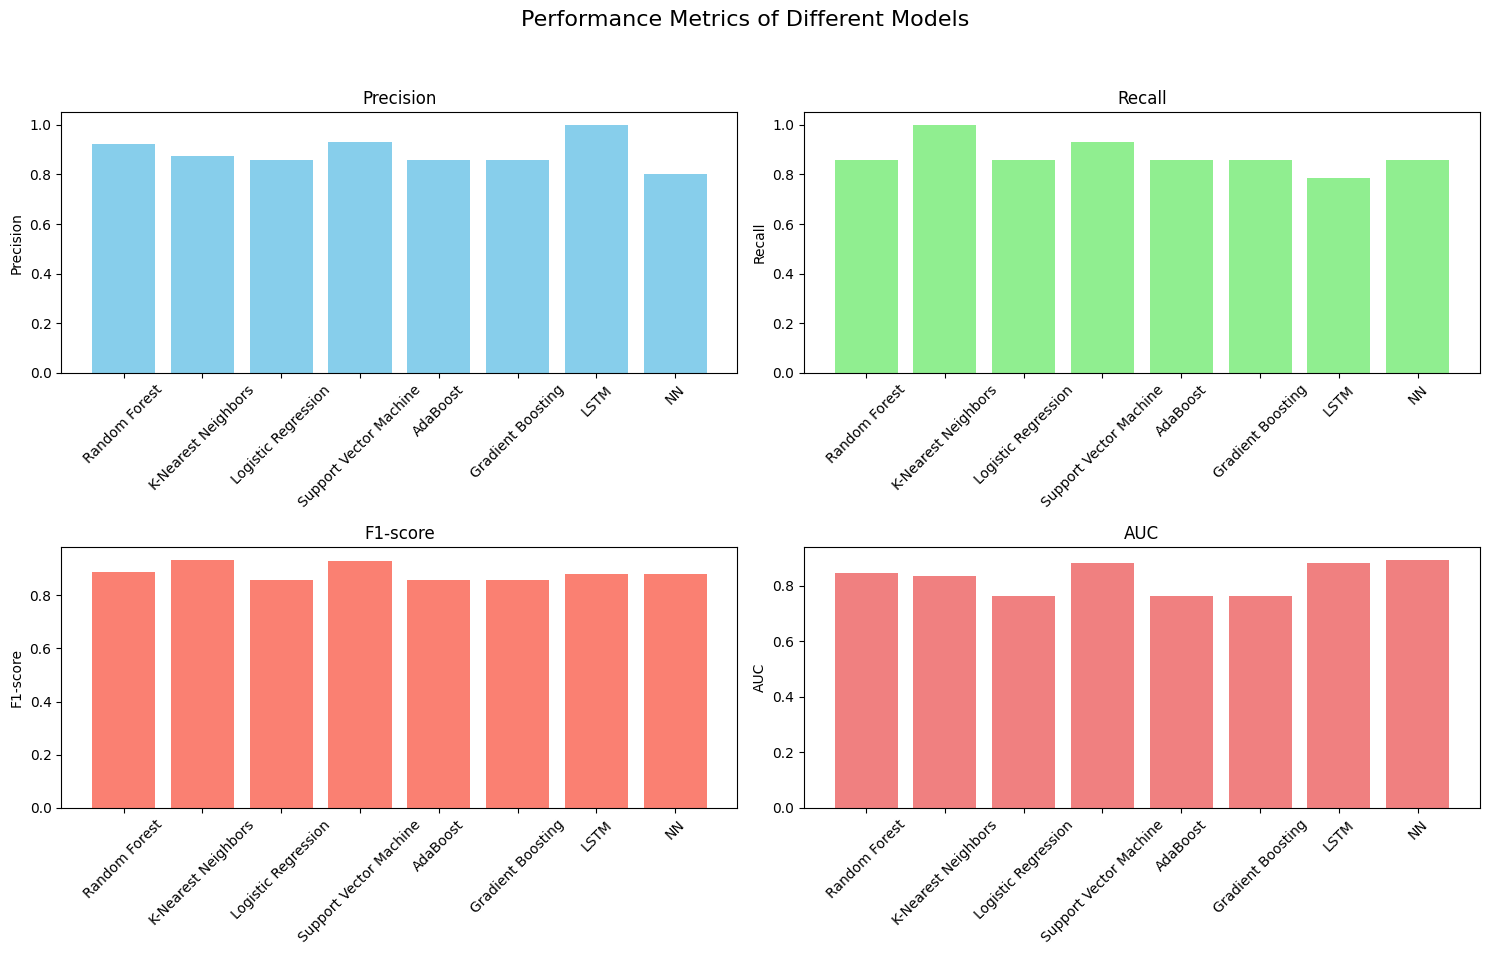

In [ ]:
performance_metrics(resampled_precision_scores, resampled_recall_scores, resampled_f1_scores, resampled_auc_scores)

In [ ]:
# Append precision, recall, and F1-score to the existing dictionaries
precision_scores['LSTM'] = precision_rnn
recall_scores['LSTM'] = recall_rnn
f1_scores['LSTM'] = f1_score_rnn
auc_scores['LSTM'] = auc_rnn


# Append precision, recall, and F1-score to the existing dictionaries
precision_scores['NN'] = precision_nn
recall_scores['NN'] = recall_nn
f1_scores['NN'] = f1_score_nn
auc_scores['NN'] = auc_nn

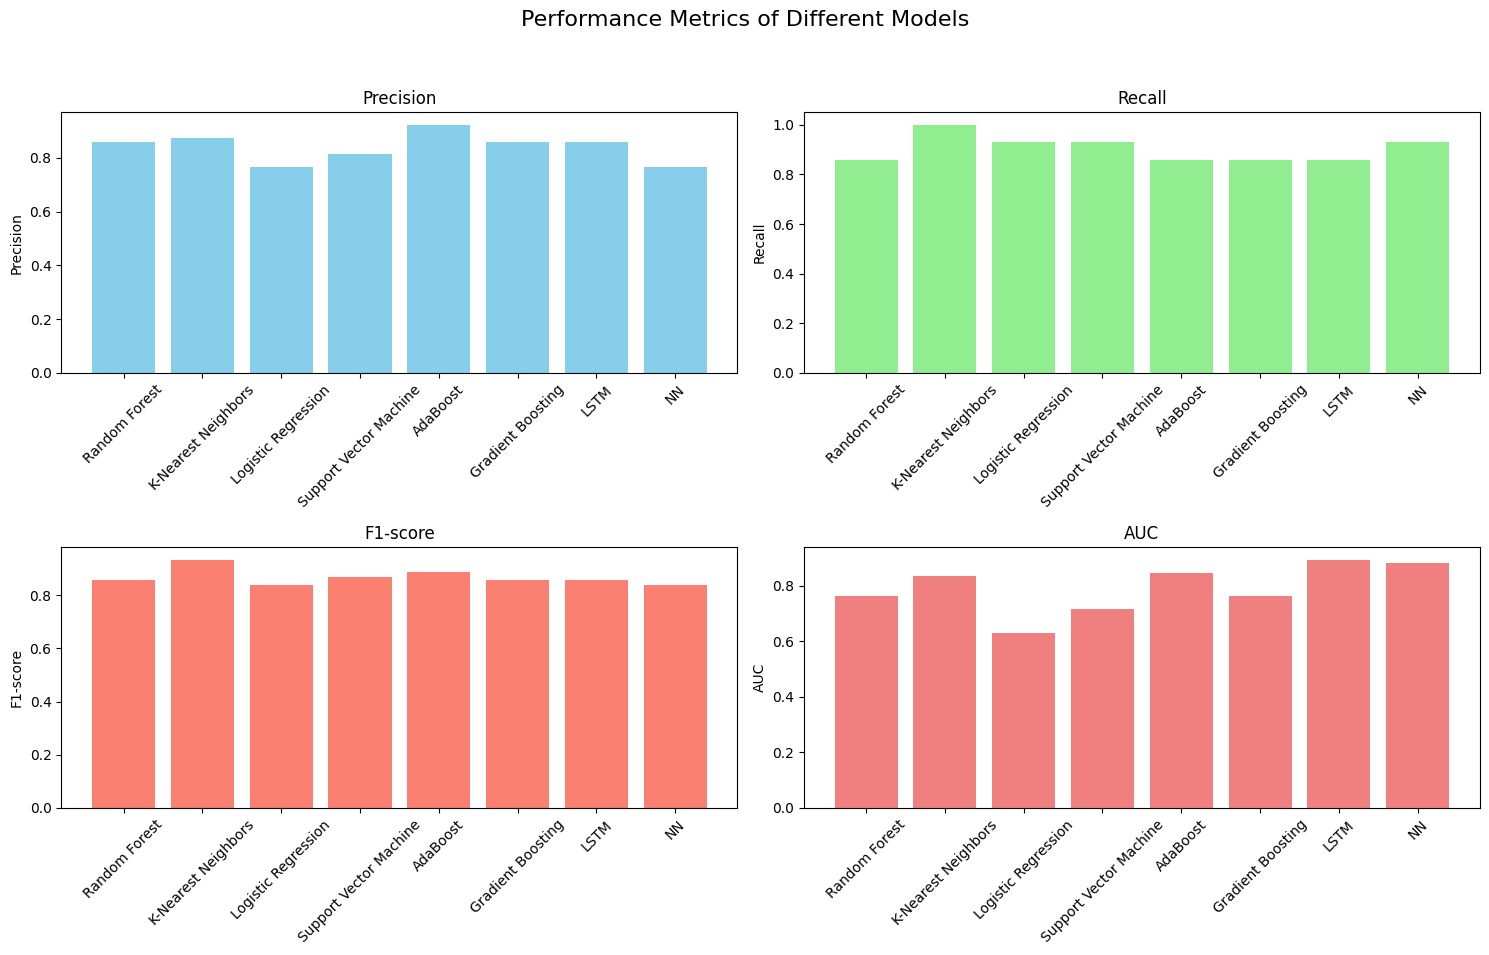

In [ ]:
performance_metrics(precision_scores, recall_scores, f1_scores, auc_scores)


# Final Prediction Function

The following function, `final_prediction_function`, takes the test data as input, preprocesses it similarly to the training data, and uses the trained LSTM model to predict class labels. The predicted labels are returned as output.


In [ ]:
# the teacher will input his test data as a txt file and my function has to return a vector of predictions 
columns = ['Class'] + [f'Time_{i}' for i in range(1, 97)]

# -------- put the path of the test data file here ----- 
path_to_test_data = 'ECG200_TEST.txt' # this is an example of a path, you can change it to the path of your test data file

test_data = pd.read_csv(path_to_test_data, delimiter='\s+', header=None, names=columns)


def test_data_prediction(test_data):
    # use knn model to predict the test data
    # the values 
    y_true = test_data['Class']
    
    test_data.drop(['Class'], axis=1, inplace=True)
    test_data = (test_data - global_min) / (global_max - global_min)
    
    y_pred = knn_model.predict(test_data)
    print(knn_model.predict(test_data))
    print(knn_model.score(test_data, y_true))
    return


test_data_prediction(test_data)

[ 1.  1. -1.  1. -1.  1. -1.  1.  1. -1. -1. -1. -1. -1. -1.  1.  1.  1.
 -1.  1. -1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1.  1. -1. -1.  1. -1.
  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1.
 -1.  1.  1. -1. -1. -1. -1.  1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1. -1. -1. -1. -1.  1.  1.
  1. -1. -1.  1.  1.  1.  1. -1. -1.  1.]
0.9
